In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import time
# import plotly.express as px
import cv2 
import seaborn as sns
from scipy.optimize import leastsq 

sns.set_style("white")

# import plotly.io as pio
# pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

In [13]:
df_488 = np.loadtxt("lens_488nm.txt")
df_561 = np.loadtxt("lens_561nm.txt")
# cv2.imshow(img_488, vmin=0, vmax=3)

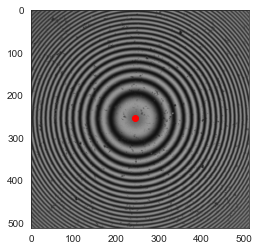

In [14]:
plt.imshow(df_488*100, cmap=plt.cm.gray, vmin=0, vmax=400)
i_cen = 245
j_cen = 252
plt.plot(i_cen, j_cen, 'or')



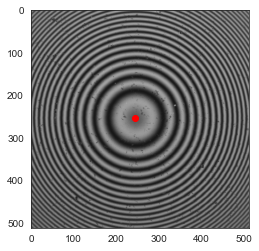

In [15]:
plt.imshow(df_561*100, cmap=plt.cm.gray, vmin=0, vmax=400)
plt.plot(i_cen, j_cen, 'or')

# Radial mean of intensity

https://github.com/mkolopanis/python/blob/master/radialProfile.py

In [16]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


In [17]:
scale = 1.273/512 # mm per px
radial_profile_488 = azimuthalAverage(df_488, [i_cen, j_cen])
n_data = len(radial_profile_488)
r_arr_488 = np.arange(n_data)*scale

radial_profile_561 = azimuthalAverage(df_561, [i_cen, j_cen])
n_data = len(radial_profile_561)
r_arr_561 = np.arange(n_data)*scale

0.3109587912086671 2.3365961538461875
0.4100025773196489 2.4127734374999648


(0.0, 0.3)

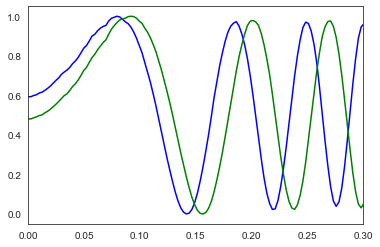

In [18]:
I_min_488 = np.amin(radial_profile_488)
I_max_488 = np.amax(radial_profile_488)
print (I_min_488, I_max_488)

radial_profile_488_norm = (radial_profile_488 - I_min_488)/(I_max_488-I_min_488)
plt.plot(r_arr_488, radial_profile_488_norm, '-b')


I_min_561 = np.amin(radial_profile_561)
I_max_561 = np.amax(radial_profile_561)
print (I_min_561, I_max_561)

radial_profile_561_norm = (radial_profile_561 - I_min_561)/(I_max_561-I_min_561)
plt.plot(r_arr_561, radial_profile_561_norm, '-g')

plt.xlim([0, 0.3])

(-0.05, 1.05)

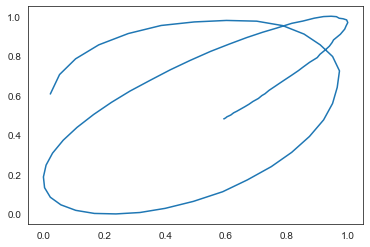

In [19]:
ind_max = np.where(r_arr_488 > 0.22)[0][0]

plt.plot(radial_profile_488_norm[:ind_max], radial_profile_561_norm[:ind_max])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])


(-0.05, 1.05)

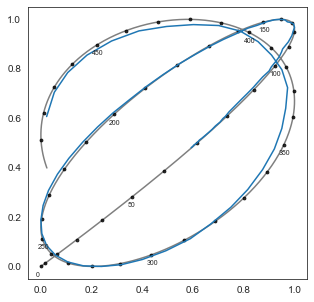

In [20]:
ls_1 = 1.0
ls_2 = 1.0
ls_3 = 0.8

ms = 8 # marker size
fs_1 = 7
fs_2 = 7

fig_4, ax_4 = plt.subplots()
fig_4.set_size_inches([5,5])

def I_func(h_air, w=530):
    
    phi = 4*np.pi*h_air/w + np.pi
#     phi = 4*np.pi*h_air/w
    I_val = 0.5 + 0.5*np.cos(phi)
    return I_val

h_start, h_end = 0, 500

h_arr_ref = np.linspace(h_start,h_end,1000)
I_arr_488 = I_func(h_arr_ref, 488)
I_arr_561 = I_func(h_arr_ref, 561)
ax_4.plot(I_arr_488, I_arr_561, '-k', alpha=0.5)

# add marker
h_marker = np.arange(h_start,h_end,10)

# plot labels 
for h_m in h_marker:
    x = I_func(h_m, 488)
    y = I_func(h_m, 561)
    
    ax_4.scatter(x, y, color="k",edgecolor = "k", 
                 marker='o', s=ms, alpha=0.8)
    
    if (h_m%50==0):
        ax_4.text(x-0.02, y-0.04, h_m, fontsize=fs_2)

# ax_4.plot(I_436_loc1, I_546_loc1, 'ob', alpha=0.1) 
# ax_4.plot(I_436_loc2, I_546_loc2, 'or', alpha=0.1) 
ax_4.plot(radial_profile_488_norm[:ind_max], radial_profile_561_norm[:ind_max])


ax_4.set_xlim([-0.05,1.05])
ax_4.set_ylim([-0.05,1.05])

In [21]:
def residual(h, params, w1 = 488, w2 = 561):
    
    I1_exp = params[0]
    I2_exp = params[1]
    return (I1_exp - I_func(h, w1))**2 + (I2_exp - I_func(h, w2))**2


    

In [22]:
ind = 0

I_488_exp = radial_profile_488_norm[ind]
I_561_exp = radial_profile_561_norm[ind]

leastsq(residual, 50, [I_488_exp, I_561_exp])



(array([68.32532112]), 3)

# Calculate height

In [23]:
h_calc = np.ones(ind_max)
h_guess = 50

for ind in np.arange(ind_max):
    
    h_calc[ind] = leastsq(residual, h_guess, [radial_profile_488_norm[ind], radial_profile_561_norm[ind]])[0][0]
    h_guess = h_calc[ind]

    

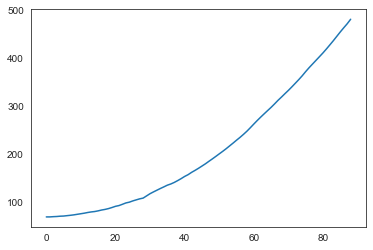

In [24]:
plt.plot(h_calc)